In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
import math

from skimage import io
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [ ]:
# This was repurposed from MatLab's tutorial on Texture-based image segmentation:
# https://www.mathworks.com/help/images/texture-segmentation-using-gabor-filters.html
def apply_seg_mask(image):
    g_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    (numRows, numCols, _) = image.shape

    wavelengthMin = 4/math.sqrt(2)
    wavelengthMax = math.hypot(numRows,numCols)
    n = math.floor(math.log2(wavelengthMax/wavelengthMin))
    wavelengths = 2 ** np.arange(0, n - 1) * wavelengthMin
    deltaTheta = 45
    orientations =  np.arange(0, 180, deltaTheta)

    # Create Gabor filters
    gabor_kernels = []
    for wavelength in wavelengths:
        for theta in orientations:
            kernel = cv.getGaborKernel((50, 50), 8, np.deg2rad(theta), wavelength, 0.5, 0)
            gabor_kernels.append(kernel)

    # Apply Gabor filters
    gabormag = np.zeros((numRows, numCols, len(gabor_kernels)), dtype=np.float32)
    for i, kernel in enumerate(gabor_kernels):
        filtered = cv.filter2D(g_image, cv.CV_32F, kernel)
        sigma = 0.5 * wavelengths[i // len(orientations)]
        filtered = cv.GaussianBlur(filtered, (5, 5), 3 * sigma)
        gabormag[:, :, i] = filtered
        

    # Create feature set (Gabor + Coordinates)
    X, Y = np.meshgrid(np.arange(numCols), np.arange(numRows))
    featureSet = np.concatenate([gabormag, X[..., None], Y[..., None]], axis=2)

    # Normalize feature set
    scaler = StandardScaler()
    X_flat = featureSet.reshape(-1, featureSet.shape[2])
    X_scaled = scaler.fit_transform(X_flat)
    featureSetNorm = X_scaled.reshape(numRows, numCols, -1)

    # K-means segmentation
    featureSetNorm = featureSetNorm.astype(np.float32)
    kmeans = KMeans(n_clusters=3, n_init=5).fit(X_scaled)
    L = kmeans.labels_.reshape(numRows, numCols)

    # Display segmentation
    L_color = cv.applyColorMap((L * 127).astype(np.uint8), cv.COLORMAP_JET)
    overlay = cv.addWeighted(image, 0.6, L_color, 0.4, 0)
    
    return overlay

def plot_images(images, titles=None, cols=3, figsize=(10, 5)):
    """
    Plots a list of images using Matplotlib.

    Parameters:
    - images: List of NumPy arrays (each image should be in grayscale or RGB format).
    - titles: List of titles corresponding to each image (default is None).
    - cols: Number of columns in the subplot grid (default is 3).
    - figsize: Tuple specifying figure size (default is (10, 5)).
    """
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=figsize)

    for i, img in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        cmap = 'gray' if len(img.shape) == 2 else None
        plt.imshow(img, cmap=cmap)
        plt.axis('off')  # Hide axes
        
        if titles and i < len(titles):
            plt.title(titles[i])

    plt.tight_layout()
    plt.show()


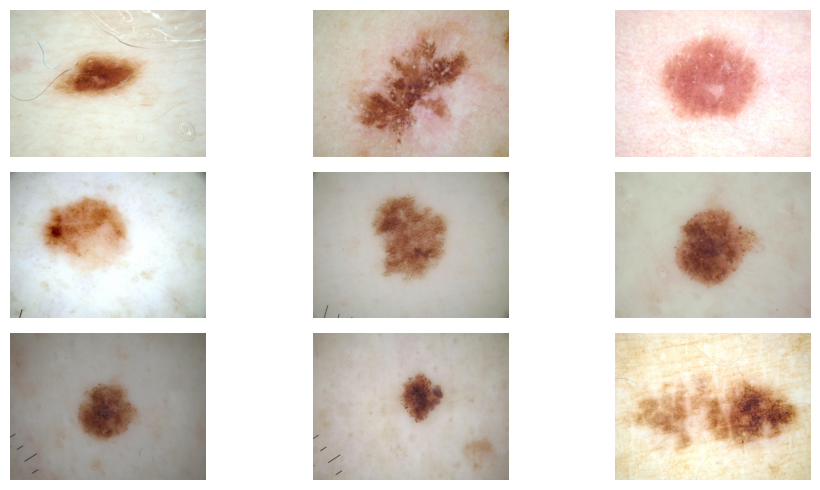

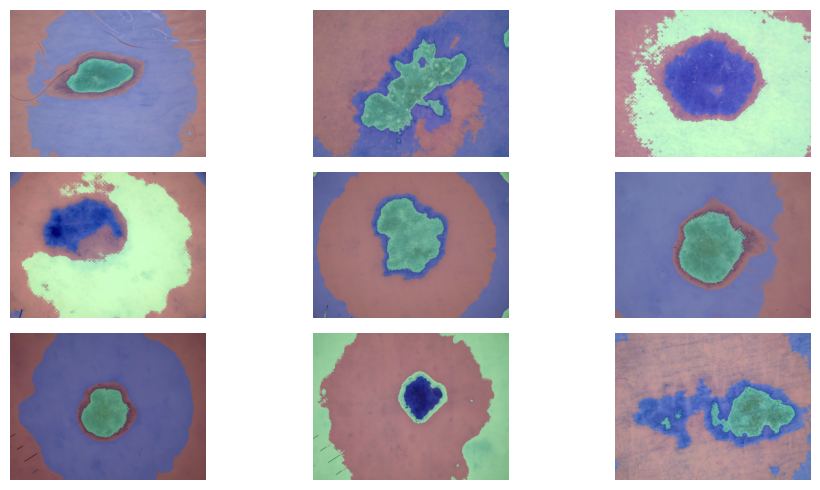

In [12]:
image_size = (244,244)
dataset = pd.read_csv(os.path.join("ISIC-images2","metadata.csv"), header = 0, nrows=50)
dataset = dataset.drop(["attribution", "copyright_license", "acquisition_day"], axis=1)
dataset["img_path"] = dataset["isic_id"].apply(lambda x: os.path.join("ISIC-images2",f"{x}.jpg"))

sample = [6,7,9,12,13,15,16,17,42]

plot_images([cv.imread(dataset["img_path"][x], cv.IMREAD_COLOR_RGB) for x in sample])
plot_images([apply_seg_mask(cv.imread(dataset["img_path"][x])) for x in sample])